### Predicting Tennis Players' Ranking ###

Tennis, a globally cherished sport, epitomizes elegance, precision, and athleticism. Played on various surfaces like grass, clay, and hard court, tennis involves players rallying a ball back and forth over a net using rackets. One crucial aspect of tennis is the occurrence of ace serves and the advantage of height. An ace serve happens when a player's serve is untouched by the opponent, leading to an instant point for the server. Additionally, taller players possess an inherent advantage on the court. Their height enables them to serve at higher speeds and provides a larger margin for error to clear the net, along with offering wider angles to target inside the service box (Hill, 2014). In the realm of tennis analytics, understanding the frequency and impact of ace serves and height advantages can offer valuable insights into player performance, strategy, and match outcomes. Therefore, the question this project aims to answer is: What correlations exist between ace serves, height advantages, and match results in professional tennis? To address this question, a comprehensive dataset comprising match statistics, including serve performance and player height, from various professional tennis tournaments was utilized. The dataset encompasses various matches played on different surfaces and includes detailed statistics on ace serves, double faults, player heights, and match outcomes. This dataset provides a rich source of information to analyze the relationship between ace serves, height advantages, and match results in professional tennis.

**---This should be fine as is, but we need 2000 words total AND two sources so maybe we could bulk this up a bit more. Might want to specify where the data comes from specifically or do that in next paragraph**

**--- NEED A LEGEND AND LABELS FOR ALL GRAPHS AND TABLES! Probably at start?**

**Preparing the Data**

After installing the relevant packages, we downloaded and read the dataset titled “Game results for Top 500 Players from 2017-2019” from the provided google drive.

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
# read the data 
# note: The code below will download the data into the current working directory and read it
url <- "https://drive.google.com/uc?export=download&id=1fOQ8sy_qMkQiQEAO6uFdRX4tLI8EpSTn"
download.file(url, "./atp2017-2019.csv")
player_result <- read_csv("./atp2017-2019.csv")

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

We then limited the dates to the year 2019 by filtering and then selected the columns of interest which included, the player’s ID, number of aces per game, and heights for both winners and losers respectively. We then merged the corresponding winner and loser columns for each attribute, which resulted in a simplified data frame consisting of 3 columns: ID, aces, and height. Therefore, each row in this frame represents a single observation. Any observations with missing values were also removed.

In [2]:
# filter year 2019, there is indeed a more formal way with more steps to do that,
# but we can simply do it this way with only one step because we don't need the
# year information later on
player_2019 <- filter(player_result, tourney_date <= 20199999
                       , tourney_date >=20190000) |>
  select(winner_id, loser_id, w_ace, l_ace, winner_ht, loser_ht)

# seperate the original data into winner and loser
player_winner <- player_2019 |>
  select(winner_id, w_ace, winner_ht, ) |>
  rename(id = winner_id, ace = w_ace, height = winner_ht)
player_loser <- player_2019 |>
  select(loser_id, l_ace, loser_ht) |>
  rename(id = loser_id, ace = l_ace, height = loser_ht)

# Combine them together by rows to form a data into a tidy format
player_clean <- bind_rows(player_winner, player_loser)|>
na.omit()
head(player_clean)

id,ace,height
<dbl>,<dbl>,<dbl>
104259,5,178
104919,7,188
104259,3,178
104926,5,178
105311,3,185
104919,2,188


Finally, we split the data into training and testing sets, allocating a 0.75 proportion to the training set.

In [3]:
# Split data into training data and testing data
set.seed(8888)
player_split <- player_clean |>
  initial_split(prop = 0.75, strata = ace)
player_training <- training(player_split)
player_testing <- testing(player_split)
head(player_training)

id,ace,height
<dbl>,<dbl>,<dbl>
104259,3,178
104919,2,188
104312,3,190
104312,2,190
104468,2,183
105357,0,183


**Exploring The Data**

After summarizing the training data, we found that the average number of aces was 6.842, and the average height was 186 cm. In addition, we ensured that all the variables of interest did not contain any missing values since this could interfere with the analysis later.

In [4]:
# Exploratory data analysis to training data
summarised_training <- player_training |>
  summarize(ace_mean = mean(ace, na.rm = TRUE),
            height_mean = mean(height, na.rm = TRUE),
            missing_id = sum(is.na(id)), 
            missing_ace = sum(is.na(ace)),
            missing_height = sum(is.na(height)))
summarised_training

ace_mean,height_mean,missing_id,missing_ace,missing_height
<dbl>,<dbl>,<int>,<int>,<int>
6.841816,186.1183,0,0,0


In order to get a sense of the range and distribution of our variables, individual scatter plots were created 

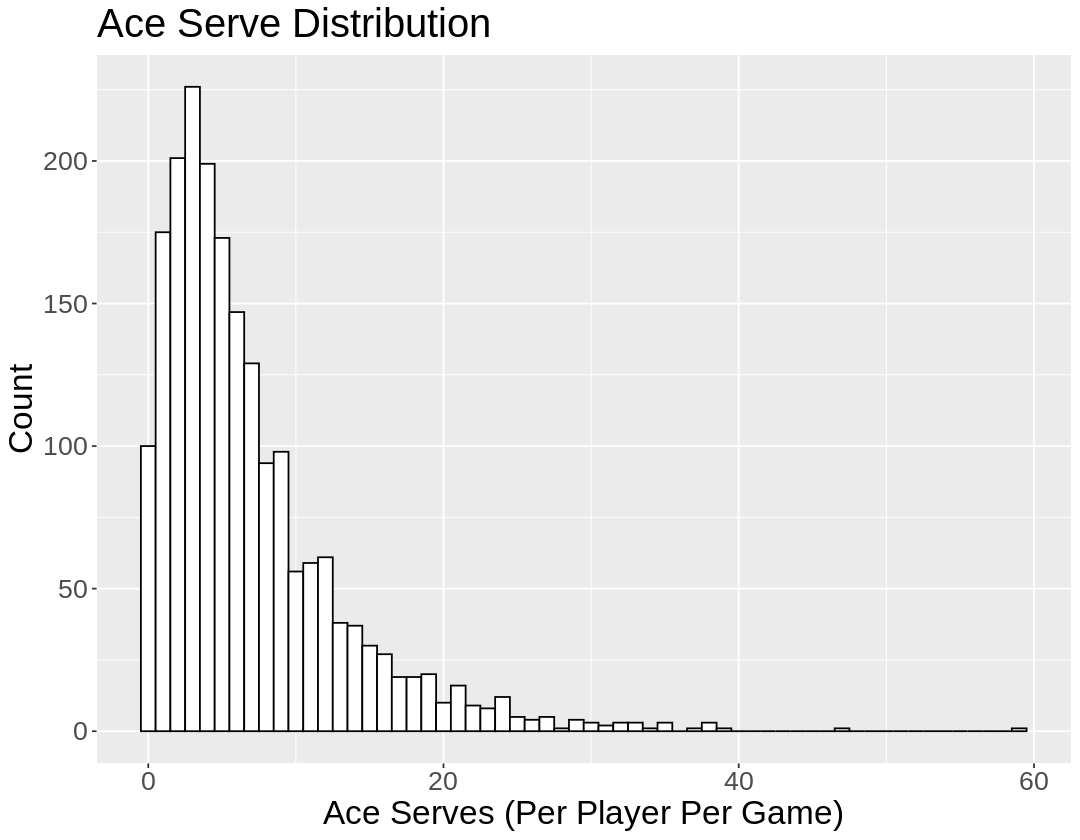

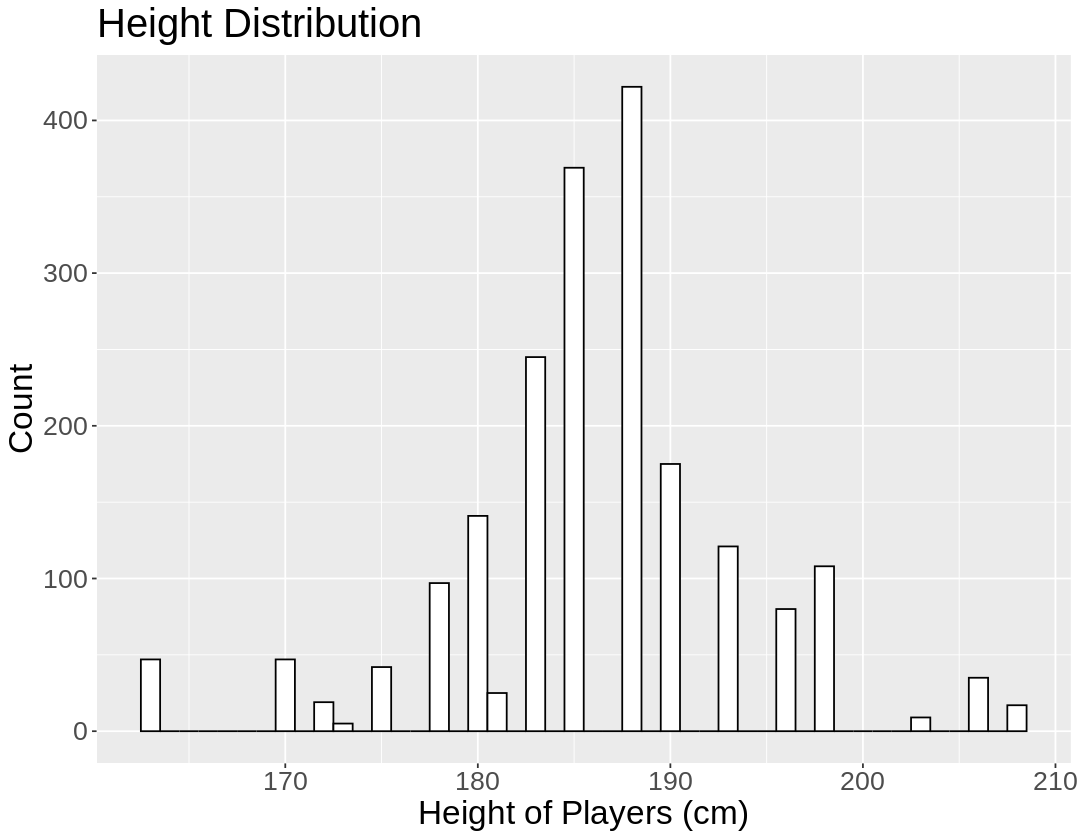

In [5]:
options(repr.plot.width = 9, repr.plot.height = 7) 

ace_plot<-ggplot(player_training, aes(x=ace))+
    geom_histogram(binwidth=1, colour="black", fill="white") +
    xlab("Ace Serves (Per Player Per Game)") +
    ylab("Count") +
    ggtitle("Ace Serve Distribution") +
    theme(text = element_text(size=20))

height_plot<-ggplot(player_training, aes(x=height))+
    geom_histogram(binwidth=1, colour="black", fill="white") +
    xlab("Height of Players (cm)") +
    ylab("Count") +
    ggtitle("Height Distribution")+
    theme(text = element_text(size=20))
ace_plot
height_plot



**Performing the Analysis**

Now we can perform the regression analysis. We do not know the optimal K value, so we will have to detremine that during the analysis.Firstly, we must create the two components in our workflow which are the model and the recipe.
We have also created some cross-validation folds for our evaluation of K which will happen later.

In [6]:
set.seed(3636)
height_spec<- nearest_neighbor(weight_func = "rectangular", neighbors =tune()) |> 
       set_engine("kknn") |>
       set_mode("regression") 

height_recipe<- recipe(ace ~ height , data =player_training) |>
       step_scale(all_predictors()) |>
       step_center(all_predictors())

height_cv<-vfold_cv(player_training, v=5, strata = ace)

We have now created a work flow and have tested multiple values of K from 1 to 81. Looking at the lowest RMSE value, we have determined that the best K value is **FIGURE OUT LATER**.

In [7]:
set.seed(3636)
height_workflow<-workflow()|>
add_recipe(height_recipe)|>
add_model(height_spec)

height_gridvals<-tibble(neighbors=seq(from=1, to=301, by=10))

height_results<-height_workflow|>
tune_grid(resamples= height_cv , grid=height_gridvals)|>
collect_metrics()

height_min<-height_results |>
    filter(.metric == "rmse") |>
    slice_min(mean, n=1)
height_min

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
281,rmse,standard,5.440968,5,0.1807258,Preprocessor1_Model29


Now that we have a tuned K value, we are able to create an optimized model and workflow for our regression analysis.

In [8]:
height_spec_tuned <- nearest_neighbor(weight_func ="rectangular", neighbors = 281) |>
          set_engine("kknn") |>
          set_mode("regression")

height_workflow_tuned <- workflow() |>
          add_recipe(height_recipe) |>
          add_model(height_spec_tuned) |>
          fit(data = player_training)

We will now see how good our regression model is by making it predict the number of aces someone did per game based off their height. This data comes from our earlier data set, but was allocated as testing data, so the model has not been trained on this data. The RMSE value indicates that this model can predict how many aces someone will acheive plus or minus five. Considering the majority of players score under ten ace serves, this model is not the most precise

In [9]:
height_summary <- height_workflow_tuned |>
           predict(player_testing) |>
           bind_cols(player_testing) |>
           metrics(truth = ace , estimate = .pred)
height_summary

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
rmse,standard,5.0729211
rsq,standard,0.2638708
mae,standard,3.6219844


**Visualizing the Analysis**

This is a visual representation of our regression model. The blue line indicates how many ace serves the model predicts based on the given height. As mentioned earlier, 

[1] ".pred"  "id"     "ace"    "height"

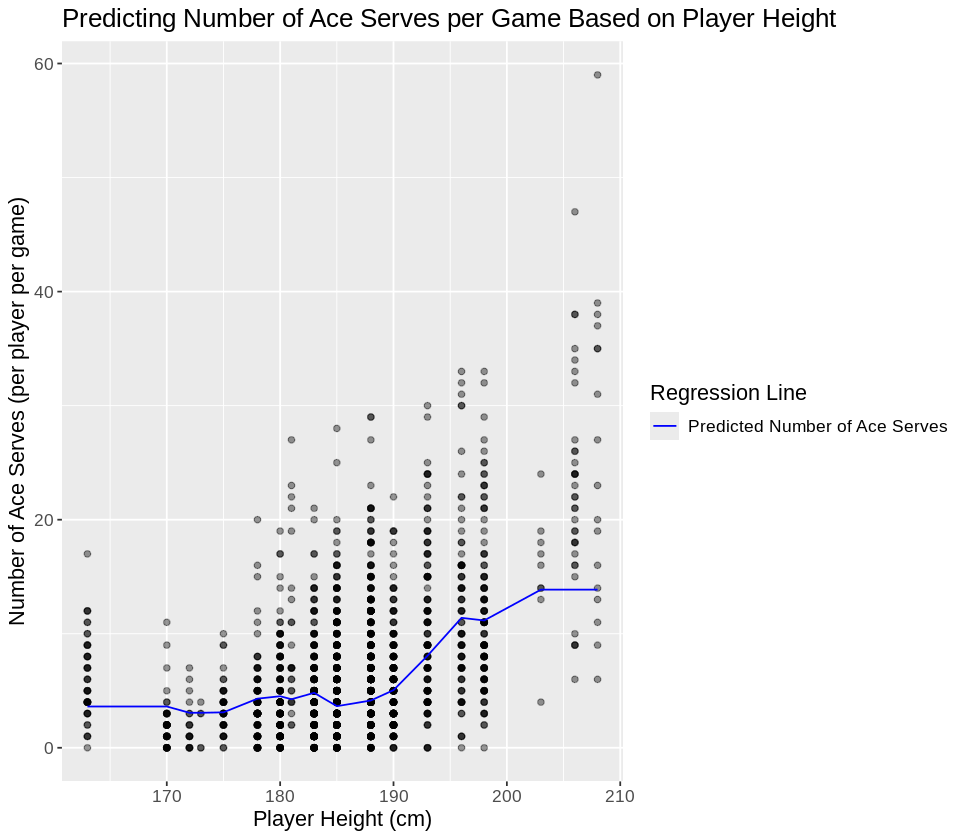

In [19]:
options(repr.plot.width = 8, repr.plot.height = 7)

analysis_preds<-predict(height_workflow_tuned, new_data=player_training)|>
bind_cols(player_training)
colnames(analysis_preds)

analysis_plot<-ggplot(analysis_preds)+
geom_point(aes(y=ace, x=height), alpha= 0.4)+
geom_line(aes(y=.pred, x=height, 
              color ="Predicted Number of Ace Serves"))+
scale_color_manual (values = c("Predicted Number of Ace Serves" = "blue")) +
labs (x = "Player Height (cm)", 
     y = "Number of Ace Serves (per player per game)",
     color = "Regression Line") +
ggtitle("Predicting Number of Ace Serves per Game Based on Player Height")+
theme (text = element_text (size = 13))
analysis_plot

**Discussion**

In our results, we found that the number of ace serves per player per game correlated with the height of the player. Although we can see in the regression that the relationship is weak, we can see that it is positive, meaning that the taller a tennis player is more likely to be able to perform an ace serve successfully in the game. Overall, our final graph, “Predicting Number of Ace Serves per Game Based on Player Height,” shows a regression to predict how many ace serves one can achieve per game depending on their height. 

At the beginning of our search, however, we did not expect to see a possible correlation between height and the number of ace serves per player per game. We were looking at other variables, such as rank and double faults. In the end, when we did come across the two variables (height and the number of ace serves per player per game), it made sense because being taller creates a greater advantage, such as getting the tennis ball over the net. 

This outcome would impact future tennis players and tennis coaches. For example, players who are a certain height can observe this data to see where they stand in terms of the number of ace serves they achieve. If they find they fall below average, they can work harder. Or if they fall right at the average, they can train even harder to get more ace serves to surprise other players who are familiar with the regression. Players can also focus on getting taller by getting nutrients or doing exercises that have been proven to work and are ethical. Moreover, shorter players can watch out for taller players because they are aware that most taller players can perform more ace serves. As for coaches, they can benefit by selecting taller tennis players because they know that taller players on average perform more ace serves in a game. These coaches would also help figure out ways for their shorter tennis players to be prepared to face taller players through training, nutrients, and other ethical solutions. 

Some future questions this activity leads to are “What are some other benefits of being taller that impact the number of ace serves one achieves (other than getting the ball over the net more easily)?”, “What other factors are there to determine how players perform ace serves better?”, “Can we estimate a player's ranking based on the ratio of height to ace serves per player per game?”, “Will the type of serve be important in the tournament as a whole?”, and “Are their variables that show a stronger correlation between height or ace serves per player per game?”.



**Bibliography**
**---Need another ref and can put where we got our data from here**

What is an Ace and Double fault in Tennis. (2010, July 1). Something about Everything. https://whyentrepreneurs.wordpress.com/2010/07/01/what-is-an-ace-and-double-fault-in-tennis/